# Определение выгодного тарифа для телеком компании

 <b>Цели исследования:</b>

Провести анализ и обработку клиентских данных сотового оператора мобильной связи «Мегалайн» по данным клиентов, перешедших на новые тарифы с целью:

- Построения системы, способной проанализировать поведение клиентов
- Предложения пользователям нового тарифа: «Смарт» или «Ультра»

<b>Ход исследования:</b>

Данные для исследования взяты из проекта курса «Статистический анализ данных». Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится.

Иследование будет включать в себя следующие шаги:

 - Подготовка данных
     - Открытие и изучение файла
     - Разделение данных на обучающую, валидационную и тестовую выборки
 - Исследование моделей машинного обучения, включающее решение поставленных задач:
     - Обучение моделей с использованием различных гиперпараметров
     - Проверка качества моделей на тестовой выборке
 - Проверка моделей на адекватность
 - Общие выводы

 <b>Результаты исследования:</b>

Удалось построить предсказательные модели, способные проанализировать поведение клиентов и предложить пользователям новые тарифы «Смарт» или «Ультра» с показателем accuracy на тестовых данных большим, чем 0,75.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score 
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit

from xgboost import XGBClassifier as xgbc

import matplotlib.pyplot as plt

### Открытие и изучение файла

In [3]:
ub = pd.read_csv('/home/panther/Documents/Deep Learning/datasets/users_behavior.csv')
ub.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
# проверка на дубликаты 

ub.duplicated().sum()

0

Распределение признаков:

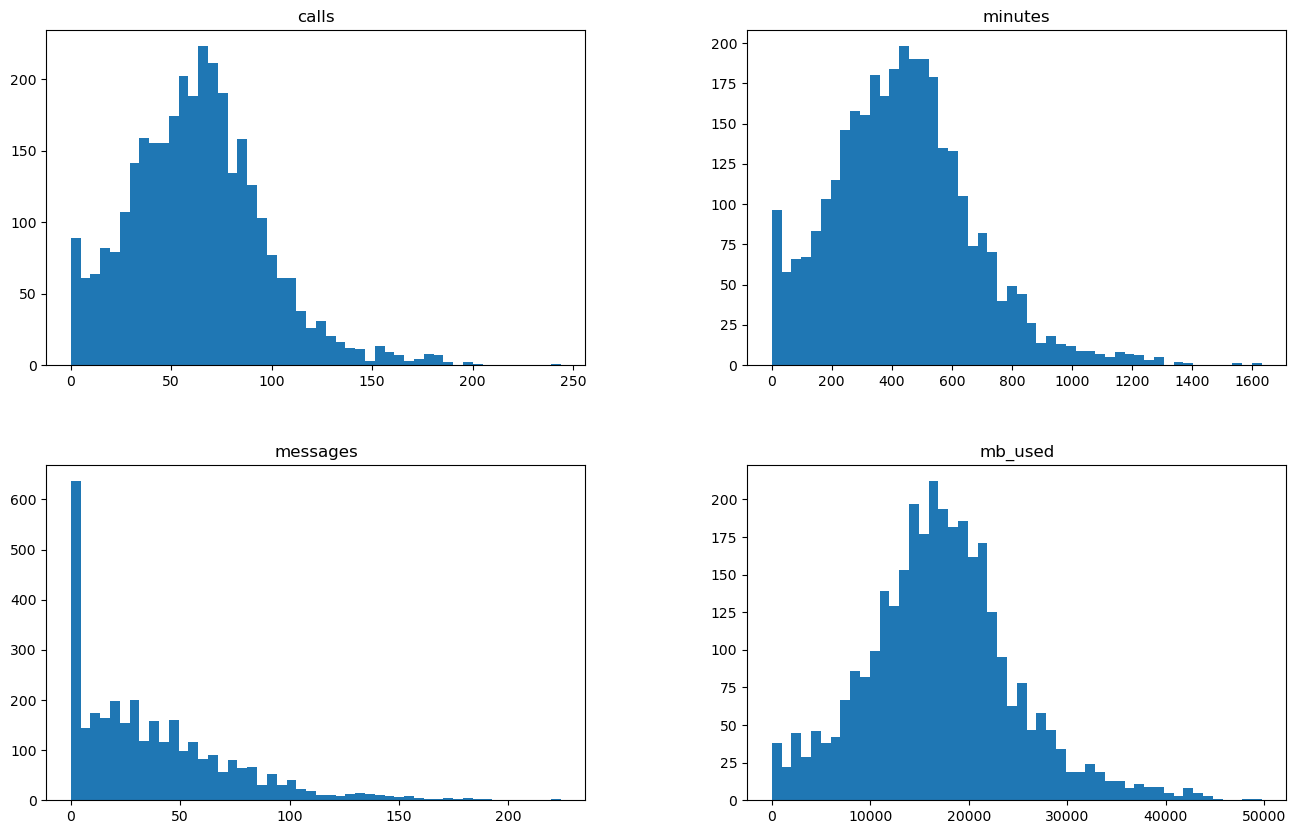

In [5]:
ub.loc[:,'calls':'mb_used'].hist(bins=50, figsize=(16, 10), grid=False);

Распределение целевой переменной:

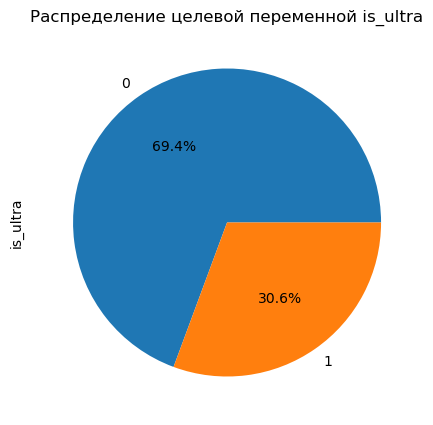

In [6]:
ub['is_ultra'].value_counts().plot.pie(figsize=(5, 5),
                                       autopct='%1.1f%%', title='Распределение целевой переменной is_ultra');

In [7]:
ub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Пропусков нет.

Проверка корреляции признаков:

In [8]:
ub.loc[:,'calls':'mb_used'].corr()

,calls,minutes,messages,mb_used
calls,1.000000,0.982083,0.177385,0.286442
minutes,0.982083,1.000000,0.173110,0.280967
messages,0.177385,0.173110,1.000000,0.195721
mb_used,0.286442,0.280967,0.195721,1.000000


Все признаки, кроме пары (`calls, minutes`), слабо скоррелированы. Пара (`calls, minutes`) скоррелирована очень сильно (к. корр. 0,98), то есть возможна мультиколлинеарность (существенно большая взаимозависимость признаков между собой, чем между признаками и целевой переменной). Мультиколлинеарность опасна в методах, основанных на линейной регрессии, потому что делает оценки неточными (растет дисперсия оценок).


### Разбивка данных на выборки

In [9]:
features_train, features_valtest, target_train, target_valtest = train_test_split(
    ub.drop('is_ultra', axis=1), ub['is_ultra'], test_size=0.3,
    stratify=ub['is_ultra'], random_state=0)

features_val, features_test, target_val, target_test = train_test_split(
    features_valtest, target_valtest, test_size=0.5,
    stratify=target_valtest, random_state=0)

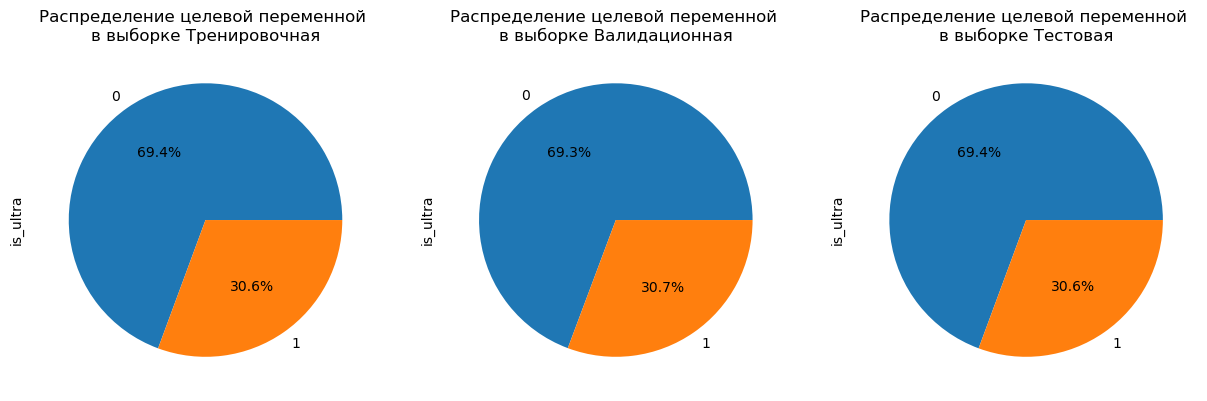

In [10]:
samples = {'Тренировочная':target_train, 'Валидационная': target_val, 'Тестовая': target_test}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, s in enumerate(samples):
    samples[s].value_counts().plot.pie(autopct='%1.1f%%',
                 title=f'Распределение целевой переменной \nв выборке {s}', ax=axes[i]);

### Выводы, подготовка данных:

- В переменную `ub` агружен файл `users_behavior.csv` в формате датафрейма. 
- Датафрейм проверен на явные дубликаты и пропуски
    - Дубликатов и пропусков не выявлено
- Для ознакомления с данными были построены гистограммы распределения числовых параметров и график долей целевой переменной
    - Все численные параметры (`calls, minutes, mb_used`) распределены одномодально и правоасимметрично, если исключить значения, равные 0
    - Классы целевой переменной `is_ultra` сбалансированы (нет перевеса в количестве значений на порядок(-дки)) 

## Исследование моделей

### Решающие деревья

In [13]:
best_acc_dt = 0

for depth in range(1, 21):
    model_dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model_dt.fit(features_train, target_train)
    pred_val_dt = model_dt.predict(features_val)
    acc_dt = accuracy_score(target_val, pred_val_dt)
    
    if acc_dt > best_acc_dt:
        best_acc_dt = acc_dt
        best_depth_dt = depth
        best_model_dt = model_dt
        
print(f'Решающие деревья. Лучшая модель: глубина дерева: {best_depth_dt}, accuracy: {best_acc_dt}')

Решающие деревья. Лучшая модель: глубина дерева: 3, accuracy: 0.8029045643153527


### Случайный лес

In [12]:
best_acc_rf = 0

for trees_n in range(2, 51, 2):
    for depth in range (1, 16):
        model_rf = RandomForestClassifier(n_estimators=trees_n, max_depth=depth, random_state=42)
        model_rf.fit(features_train, target_train)
        pred_val_rf = model_rf.predict(features_val)
        acc_rf = accuracy_score(target_val, pred_val_rf)

        if acc_rf > best_acc_rf:
            best_trees_n = trees_n
            best_acc_rf = acc_rf
            best_depth_rf = depth
            best_model_rf = model_rf

print(f'Случайный лес. Лучшая модель: количество деревьев: {best_trees_n}, \
глубина дерева: {best_depth_rf}, accuracy: {best_acc_rf}')

Случайный лес. Лучшая модель: количество деревьев: 44, глубина дерева: 7, accuracy: 0.8360995850622407


### Логистическая регрессия

In [86]:
best_acc_lgr = 0


for c in [100, 10, 1, 0.1, 0.01, 0.001]:
    model_lgr = LogisticRegression(C=c, random_state=42, penalty='l1', solver='liblinear')
    model_lgr.fit(features_train, target_train)
    pred_val_lgr = model_lgr.predict(features_val)
    acc_lgr = accuracy_score(target_val, pred_val_lgr)
    
    if acc_lgr > best_acc_lgr:
        best_acc_lgr = acc_lgr
        best_C = c
        best_model_lgr = model_lgr
        
print(f'Логистическая регрессия. Лучшая модель: C: {best_C}, accuracy: {best_acc_lgr}')

Логистическая регрессия. Лучшая модель: C: 100, accuracy: 0.7572614107883817


In [23]:
model_lgr = LogisticRegression(random_state=42, max_iter=9999)
parameters_grid = {
    'C' : [100, 50, 10, 1, 0.1, 0.05, 0.01, 0.001],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'] 
}


cv = StratifiedShuffleSplit(n_splits=5, test_size = 0.2)
grid_cv = GridSearchCV(model_lgr, parameters_grid, scoring='accuracy', cv=cv)
grid_cv.fit(features_train, target_train)
print(grid_cv.best_estimator_)
print(grid_cv.best_score_) 



/home/panther/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/panther/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/panther/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:415: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/home/panther/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/home/panther/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearch

/home/panther/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/panther/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/panther/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/panther/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/panther/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:415: LineSearchWarning: Rounding e

LogisticRegression(C=100, max_iter=9999, penalty='l1', random_state=42,
                   solver='liblinear')
0.7511111111111111


/home/panther/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
440 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/home/panther/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/panther/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/panther/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 61, in _ch

### Градиентный бустинг

In [87]:
best_acc_gb = 0


for depth in range(1, 100):
    model_gb = xgbc(eta=0.1, max_depth=depth, random_state=42)
    model_gb.fit(features_train, target_train)
    pred_val_gb = model_gb.predict(features_val)
    acc_gb = accuracy_score(target_val, pred_val_gb)

    if acc_gb > best_acc_gb:
        best_lr = lr
        best_acc_gb = acc_gb
        best_depth_gb = depth
        best_model_gb = model_gb

print(f'Градиентный бустинг. Лучшая модель: глубина деревьев: {best_depth_gb}, \
learning rate: {best_lr}, точность: {best_acc_gb}')

Градиентный бустинг. Лучшая модель: глубина деревьев: 3, learning rate: 1.0, точность: 0.8319502074688797


График и таблица показателей accuracy на тренировочной и валидационной выборке:

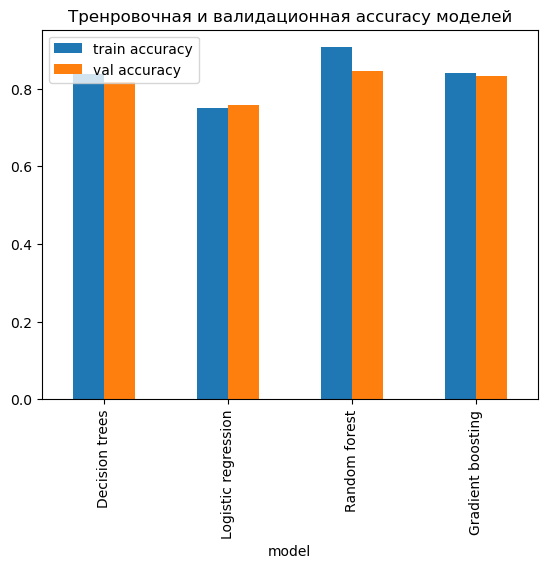

In [88]:
models = {'Decision trees': best_model_dt, 'Logistic regression': best_model_lgr,
          'Random forest': best_model_rf, 'Gradient boosting': best_model_gb}

results = pd.DataFrame({'model': [name for name in models.keys()],
              'train accuracy': [m.score(features_train, target_train) for m in models.values()],
              'val accuracy' : [m.score(features_val, target_val) for m in models.values()]}).set_index('model')

results.plot.bar(title='Тренровочная и валидационная accuracy моделей');

In [89]:
results.sort_values(by='val accuracy', ascending=False)

,train accuracy,val accuracy
model,,
Random forest,0.906625,0.844398
Gradient boosting,0.839040,0.831950
Decision trees,0.838150,0.817427
Logistic regression,0.749222,0.757261


Видно, что модель Случайного леса показывает наилучшие результаты, для дальнейшей проверки на тестовой выборке выбирается она (`best_model_rf`).

### Проверка выбранной модели на тестовой выборке

In [90]:
best_model_rf.score(features_test, target_test)

0.8033126293995859

### Вывод, исследование моделей

На задаче бинарной классификации были исследованы модели Случайных деревьев, Логистической регрессии, Случайного леса и Градиентного бустинга.

 - Были протестированы различные гиперпараметры и выбраны те, которые позволили достичь максимльной accuracy:
     - Для решающих деревьев были протестированы различные глубины (от 1 до 20), максимальный accuracy при глубине 9.
     - Для случайного леса - параметры количества дереьев и глубины дерева (42 и 13 соответственно)
     - Для логистической регрессии - параметр С (множитель регуляризации), C = 0,1
     - Градиентный бустинг - скорость обучения (eta) и глубину деревьев (0,1 и 6 соответственно) 
 - И на тренировочных, и на валидационных, и на тестовых данных лучше всего по метрике accuracy себя показала модель случайного леса (0,92 на тренировочных, 0,82 на валидационных, 0,8 на тестовых) 
 

## Проверка моделей на адекватность

Для наглядности дублирую распределение целевого показателя:

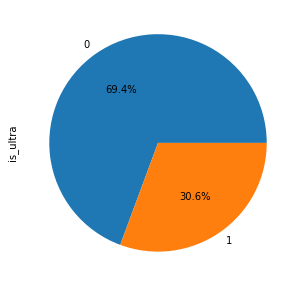

In [16]:
ub['is_ultra'].value_counts().plot.pie(figsize=(5, 5), autopct='%1.1f%%');

Если предсказывать класс случайным образом, то с вероятностью 69,4% получится класс 0 (тариф "Смарт") и с вероятностью 30,6% класс 1 (тариф "Ультра"). То есть если предсказывать тариф "Смарт", то случайным образом удачно предсказать можно почти в 7 случаях из 10. Если модель предсказывает с меньшим точностью (но выше 30,6%), то это неадекватная модель.

Если же точность предсказания ниже 30,6%, то стоит поменять предсказываемые значения местами, получив точность выше 69,4%

Проверка с помощью dummy classifier:

In [17]:
model_dc = DummyClassifier()
model_dc.fit(features_train, target_train)
pred_val = model_dc.predict(features_val)
accuracy_score(target_val, pred_val)

0.6936236391912908

Резултат аналогичен. Пороговые значения параметра accuracy для "адекватных" моделей - выше 0,694 или ниже 0,306

## Итоговый вывод:




В ходе исследования были проведены анализ и обработка клиентских данных сотового оператора мобильной связи «Мегалайн».
Получены следующие результаты:

- И на тренировочных, и на валидационных, и на тестовых данных лучше всего по метрике accuracy себя показала модель случайного леса (0,92 на тренировочных, 0,82 на валидационных, 0,8 на тестовых) 

- Анализ распределения целевой переменной и применение dummy classifier показывают, что случайным образом удачно предсказать класс 0 можно почти в 7 случаях из 10. Если модель предсказывает с меньшим точностью (но выше 30,6%), то это неадекватная модель.  
Если же точность предсказания ниже 30,6%, то стоит поменять предсказываемые значения местами, получив точность выше 69,4%

- Удалось построить предсказательные модели, способные проанализировать поведение клиентов и предложить пользователям новые тарифы «Смарт» или «Ультра» с показателем accuracy на тестовых данных большим, чем 0,75.